# Estimation and testing procedures using multiple repetitions of the process

In [1]:
from functions.hawkes_process import *
from functions.GOF import *
from functions.compensator import *
from functions.multivariate_exponential_process import *
import scipy
from functions.estimator_class_multi_rep import *


In [2]:
np.random.seed(0)

In this notebook, we present the different class and function allowing for the estimation of the parameter defining the Hawkes process when several repetition of the process are available. 

In [7]:
## parameters
m=1
a = -0.6
b = 1

## simulation 

tList = []
for k in range(200):
    hawkes_ex =   exp_thinning_hawkes(m=m, a = a, b=b, max_jumps=500)
    hawkes_ex.simulate()    
    tList += [hawkes_ex.timestamps]   

In [8]:
print(f'Correspond to Tmax = {np.mean([x[-1] for x in tList ])}')

Correspond to Tmax = 797.6210882653669


## Test on the coefficients of the model

We present here two tests available when multiple repetitions of the process are accessible. One allows testing whether a coefficient equals a specific predefined value, and the other allows testing the equality between coefficients of the process.

### Test of a specific value for one coefficient

In [9]:
## fitting the process
learner_hawkes = estimator_unidim_multi_rep()
learner_hawkes.fit(tList, max_jump = True)

array([ 1.01072115, -0.61684374,  1.02111929])

Hypothesis under test: $\mathcal{H}_0 : m = 1 \quad \text{ vs } \quad \mathcal{H}_1 : m \ne 1$.

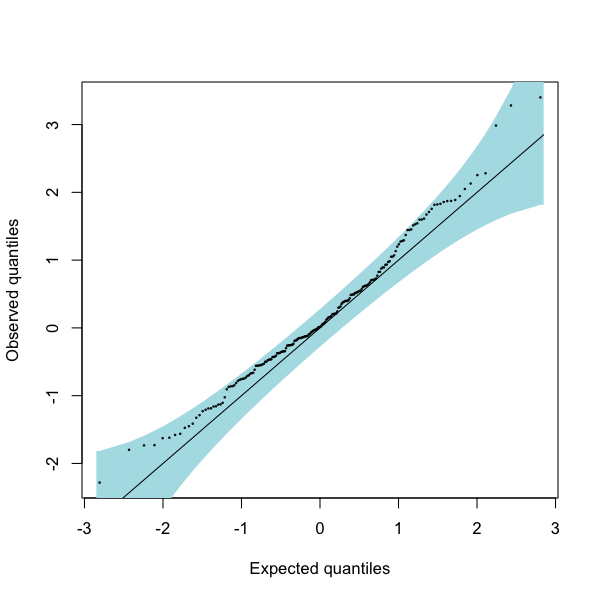

In [10]:
stat = learner_hawkes.test_one_coeff(0,1, plot=True)  

Hypothesis under test: $\mathcal{H}_0 : a = -1 \quad \text{ vs } \quad \mathcal{H}_1 : a \ne -1$.

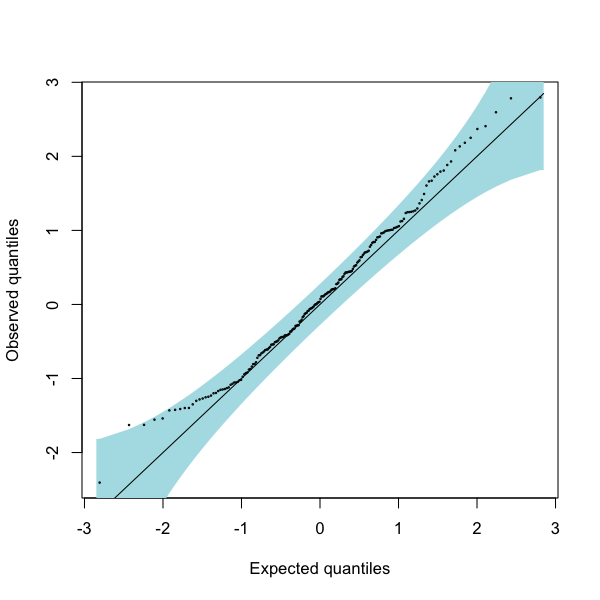

In [11]:
stat = learner_hawkes.test_one_coeff(-1,1, plot = True)  

### Test of equality between coefficients 

Hypothesis under test: $\mathcal{H}_0 : a = m \quad \text{ vs } \quad \mathcal{H}_1 : a \ne m$.

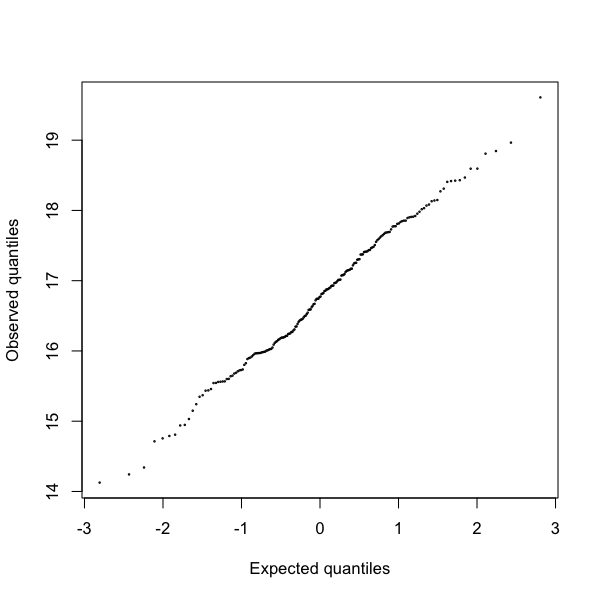

In [12]:
stat = learner_hawkes.test_equality_coeff(0,1)

## Test on the model used for estimation
We present here different tests on the model associated with the data, relying on the GOF procedure.

### Test of the self-exciting assumption

Hypothesis under test: $$\mathcal{H}_0 : \text{Data are i.i.d. representations of a Poisson model with an unknown parameter}$$

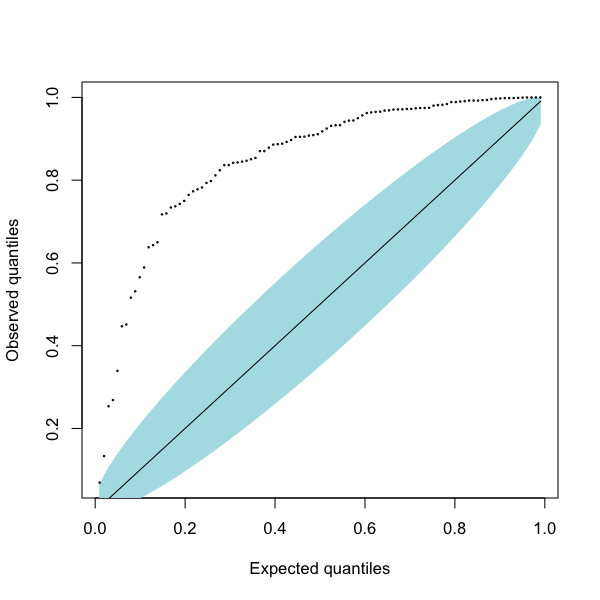

In [13]:
## Simulation done with Hawkes process with inhibition and test performed for a Poisson process

learner_poisson = estimator_unidim_multi_rep(loss = likelihood_Poisson)
learner_poisson.fit(tList,max_jump = True)
stats_poisson = learner_poisson.GOF_bootstrap(compensator_func=poisson_compensator,
                                              test_type = 'uniform', 
                                              Nb_SubSample=100, 
                                              plot = True)

We compare this result to the one obtain when testing the following null hypothesis. 
 $$\mathcal{H}_0 : \text{data are i.i.d represetation of a Hawkes model } $$

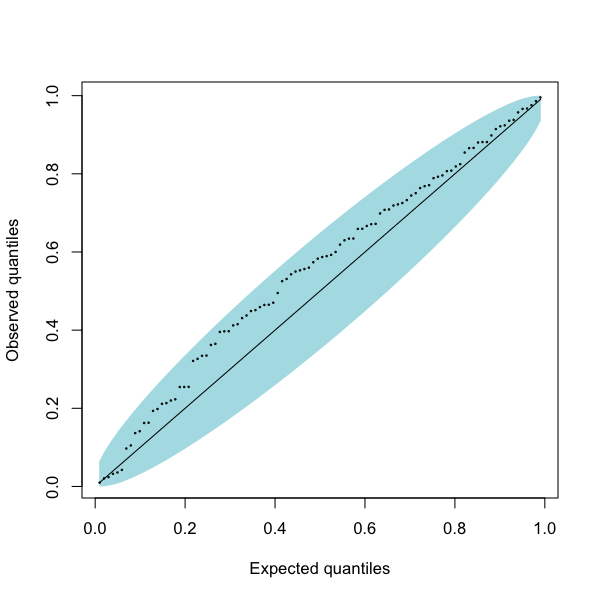

In [14]:
## Simulation done with Hawkes process with inhibition and test performed for a Hawkes process

stat_hawkes = learner_hawkes.GOF_bootstrap(test_type = 'uniform', 
                            Nb_SubSample=100, 
                            plot = True)

### Test of the inhibition assumption

We test here the null hypothesis $$\mathcal{H}_0 : \text{data are i.i.d represetation of a Hawkes model inhibition} $$

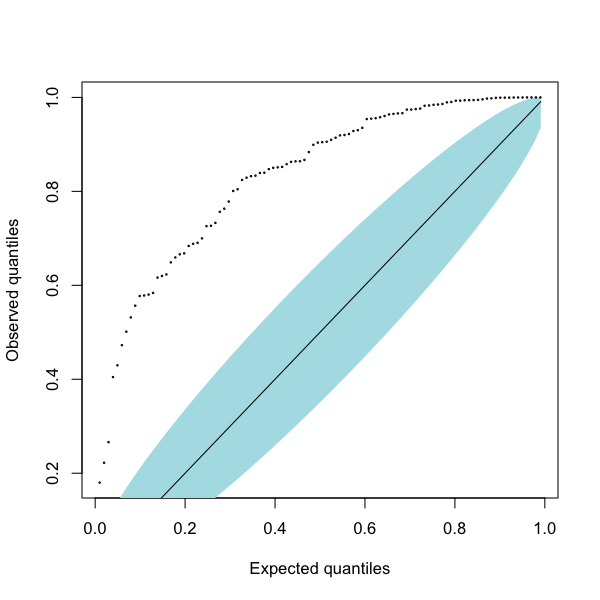

In [15]:
## Simulation done with Hawkes process with inhibition and test performed for a Hawkes process without inhibition

learner_hawkes_ex = estimator_unidim_multi_rep(a_bound=0)
learner_hawkes_ex.fit(tList, max_jump = True)
stats_hawkes_ex = learner_hawkes_ex.GOF_bootstrap(compensator_func=unidim_EHP_compensator,
                                              test_type = 'uniform', 
                                              Nb_SubSample=100, 
                                              plot = True)

### Test of the marked assumpation

We test here the null hypothesis :  $$\mathcal{H}_0 : \text{data are i.i.d represetation of a marked Hawkes model} $$

In [17]:
from functions.paramtrised_function import *


m,a,b = 1, -1, 2


tlist, mlist = [], []

for k in range(200):
    hawkes = exp_thinning_hawkes_marked(m=m,
                                            a=a, 
                                            b=b, 
                                            F=F, 
                                            arg_F={'psi':2}, 
                                            phi=phi, 
                                            arg_phi={'gamma':1}, 
                                            max_jumps=500)
    hawkes.simulate()
    tlist +=[[(time, mark) for time, mark in zip(hawkes.timestamps, hawkes.mark_list)]]

In [18]:
learner = estimator_unidim_multi_rep(mark = True, 
                                        f = f, 
                                        phi = phi, 
                                        name_arg_f=['psi'], 
                                        name_arg_phi=['gamma'], 
                                        initial_guess_phi=[0], 
                                        initial_guess_f=[1], 
                                        bound_f=[(1e-5, None)], 
                                        bound_phi=[(None, None)])

learner.fit(tlist, max_jump=True)

array([ 2.48360557,  1.03814335,  1.00418416, -0.90777153,  2.07792591])

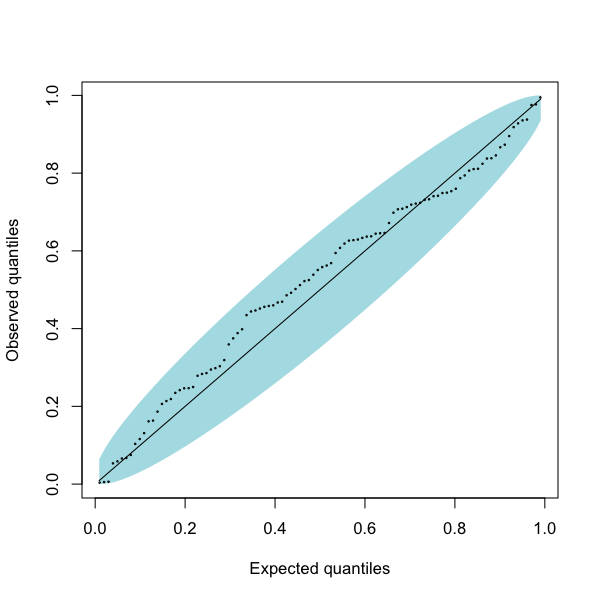

In [19]:
## Simulation done with a Marked Hawkes Process test performed for a Marked Hawkes Process 

pvals =learner.GOF_bootstrap(compensator_func=unidim_MEHP_compensator,
                             test_type = 'uniform', 
                                Nb_SubSample=100, 
                                plot = True)

# Real dataset

In [20]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [24]:
df = pd.read_csv('earthquake.txt')

### Stationnarity study

We try here to find a scale at wich the process seem stationnary. To that end we start by displaying the number of event happening per day / month / year. 

In [25]:
format='%Y-%m-%d %H:%M:%S'

df['datetime'] =df['date'].apply(lambda x : datetime.datetime.strptime(x[:19], format))
df['month'] = df['datetime'].apply(lambda x : (int(x.year)-1990)*12 + int(x.month) )
df['day'] = df['datetime'].apply(lambda x :(datetime.date(x.year, x.month, x.day) - datetime.date(1990, 1, 1)).days )
df['year'] = df['datetime'].apply(lambda x : x.year)


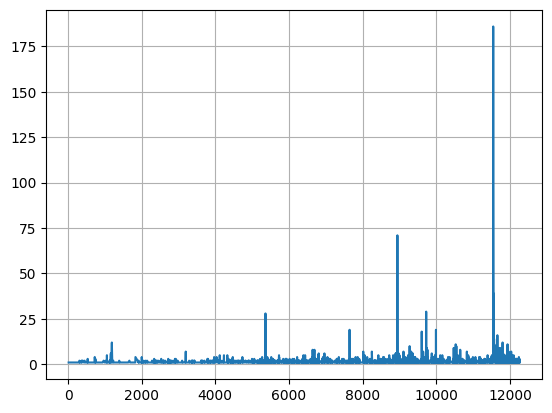

In [26]:
window = len(df)
start = 0


data_month = df.groupby('day').apply(len,include_groups=False).reset_index(name='nb_event')

plt.figure()
plt.clf()
plt.plot(data_month['day'].tolist()[start : start+window], data_month['nb_event'].tolist()[start : start+window])

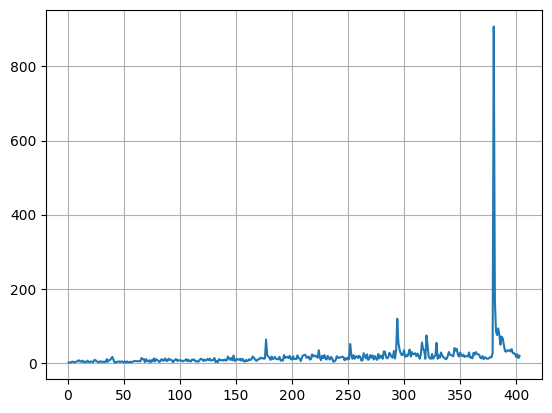

In [27]:
data_month = df.groupby('month').apply(len,include_groups=False).reset_index(name='nb_event')

plt.figure()
plt.clf()
plt.plot(data_month['month'].tolist(), data_month['nb_event'].tolist())

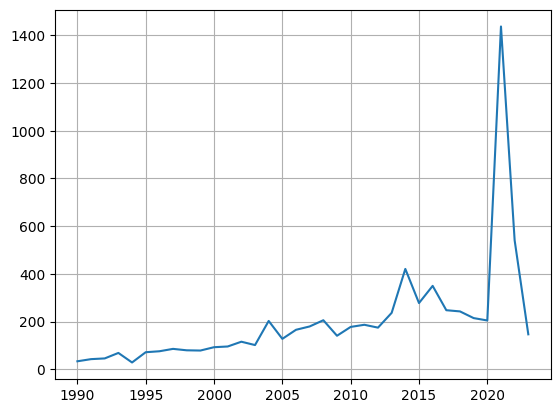

In [28]:
data_month = df.groupby('year').apply(len,include_groups=False).reset_index(name='nb_event')

plt.figure()
plt.clf()
plt.plot(data_month['year'].tolist(), data_month['nb_event'].tolist())

Based on the previous graphs, we have chosen the day as the unit of measurement. As a result, we convert the process and the associated differences into days. We are now looking for time periods that will serve as repetitions. The goal is to find periods long enough to achieve stationarity and to ensure that at the end and beginning of each period, the process returns to its baseline intensity.

In [29]:
scale = 60*60*24

df['day_diff'] = df['datetime'].apply(lambda x : (x-datetime.datetime(1990, 1,1, 0,0,0)).total_seconds()/scale )

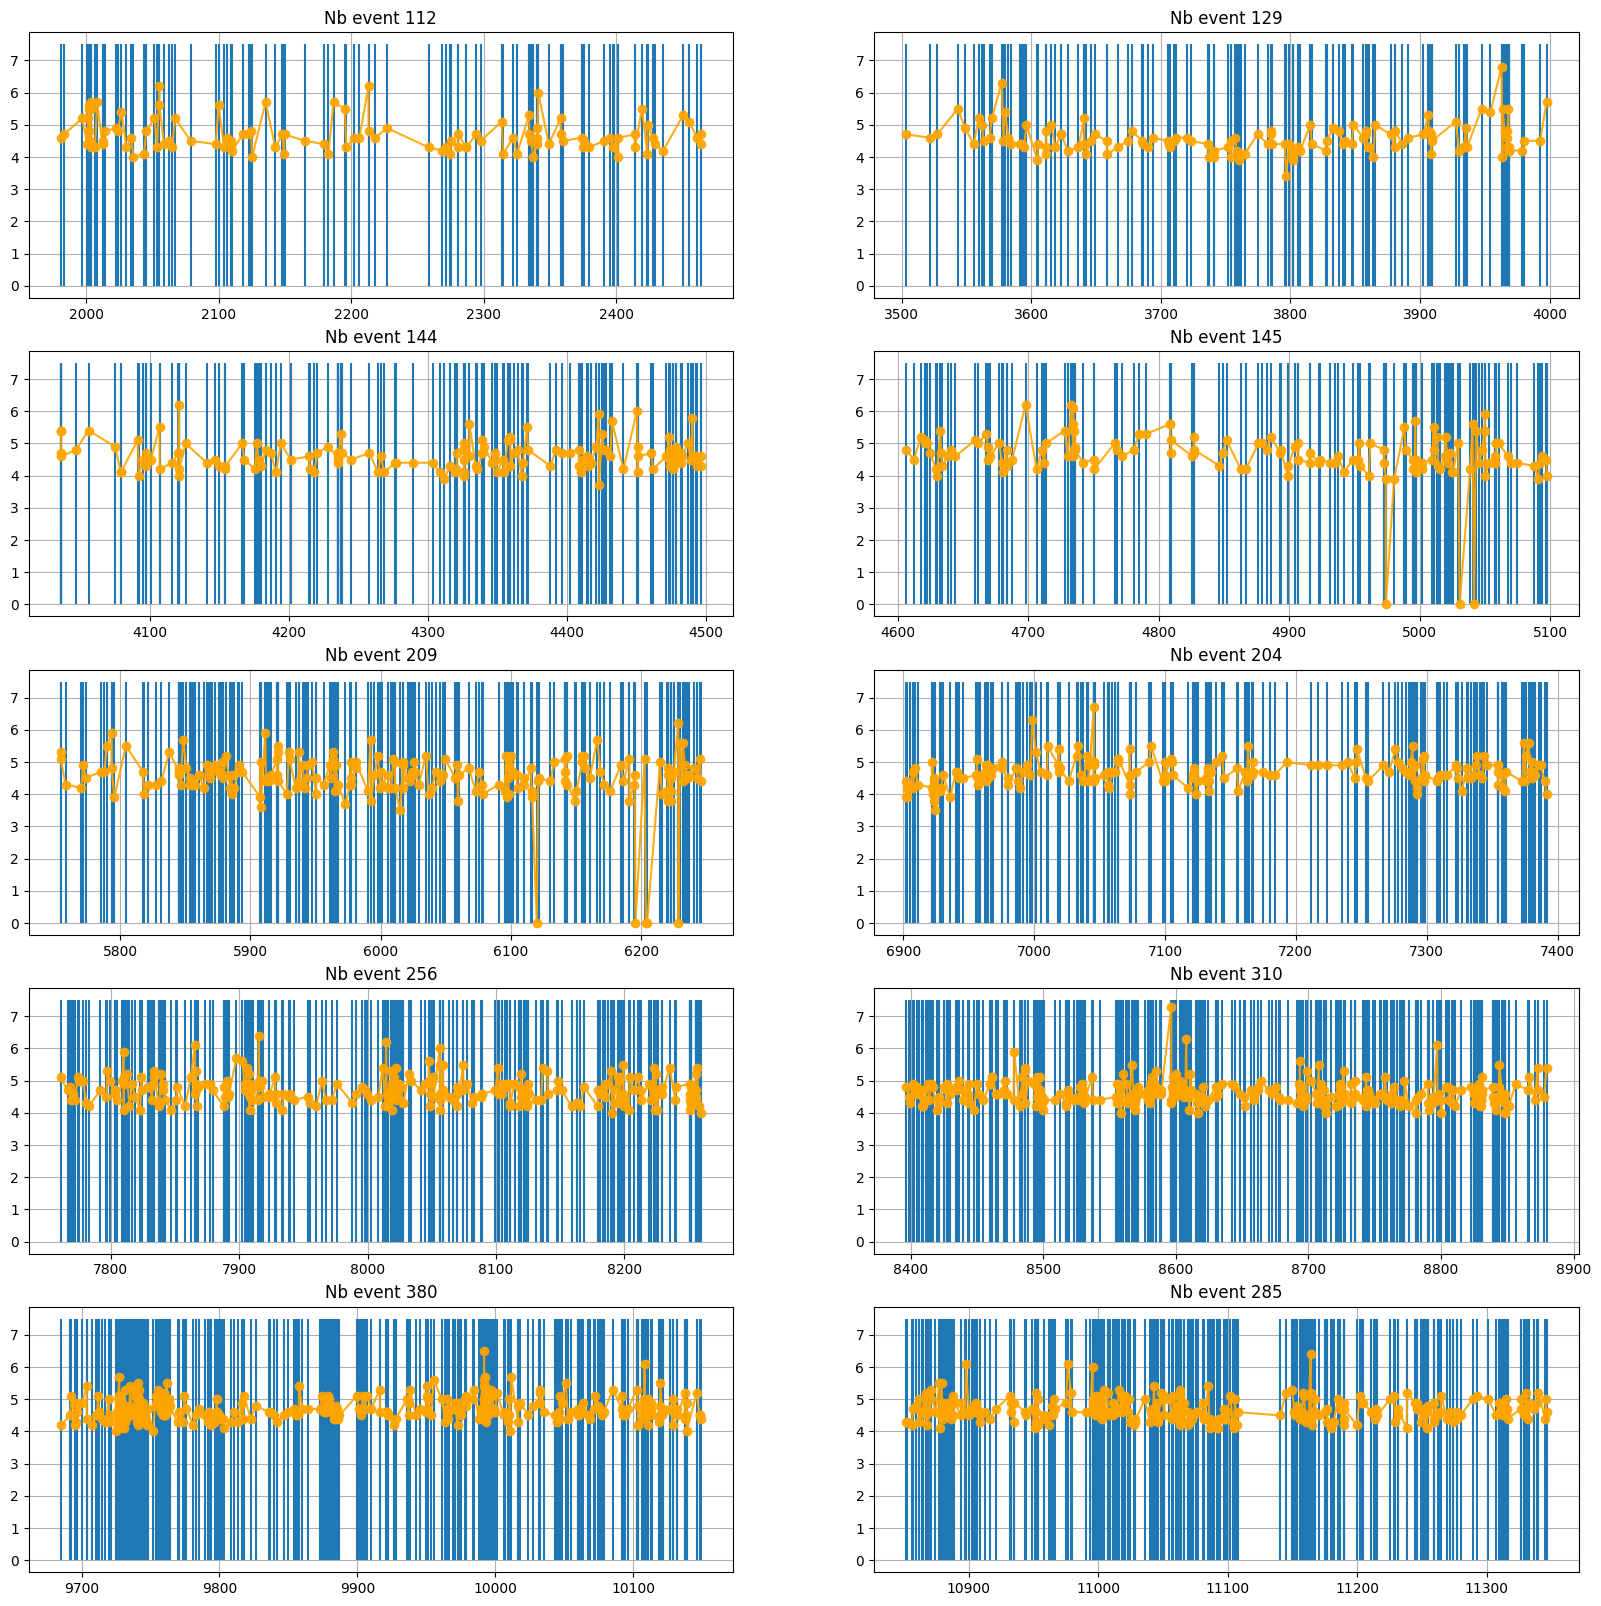

In [76]:
period = np.array([ [1980, 2480], [3500, 4000], [4000,4500], [4600,5100], [5750, 6250], [6900, 7400], [7760, 8260], [8380, 8880], [9680, 10150], [10850,11350]])

fix, ax = plt.subplots( 5,2 , figsize=(20,20))

for k in range(10):
    i,j = k // 2, k%2
    selected_event = df.loc[ (df.day_diff<=period[k,1]) &  (period[k,0] <= df.day_diff), : ]
    ax[i,j].vlines(selected_event['day_diff'].tolist(), ymin=0, ymax=7.5)
    ax[i,j].set_title(f'Nb event {len(selected_event)}')
    ax[i,j].plot( selected_event['day_diff'].tolist() , selected_event['magnitudo'].tolist(), color='orange', marker='o',alpha = 0.9)


In [61]:
## test Hawkes

tlist,tlist_marked = [],[]
for k in range(len(period)):
    selected_period = df.loc[ (df.day_diff<=period[k,1]) &  (period[k,0] <= df.day_diff),['day_diff', 'magnitudo']]
    selected_period['day_diff'] = selected_period['day_diff'] - period[k,0]
    
    tlist_marked +=  [[(0,0)] +list(selected_period.itertuples(index=False, name = None))+ [(500, 0)]]
    tlist +=  [[0] +list(selected_period.loc[:,'day_diff'].tolist())+ [500]]


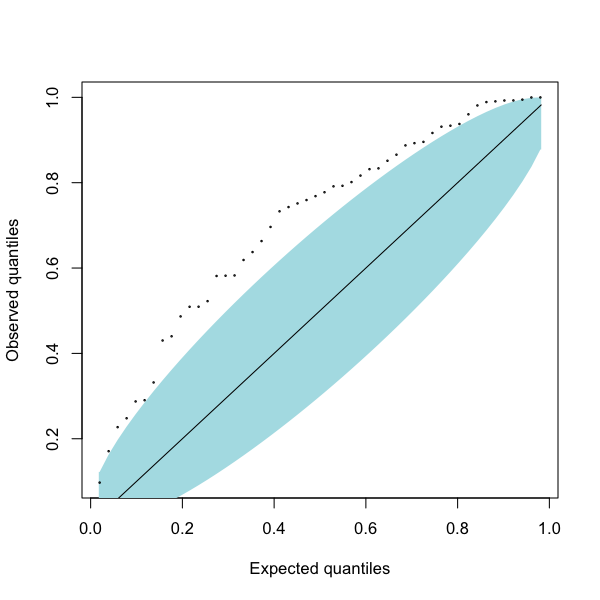

In [72]:
from function_test import f, phi1

learner_marked_hawkes = estimator_unidim_multi_rep(mark = True, 
                                                        f = f, 
                                                        phi = phi1, 
                                                        name_arg_f=['psi'], 
                                                        name_arg_phi=['gamma'], 
                                                        initial_guess_phi=[0], 
                                                        initial_guess_f=[1],
                                                        bound_f=[(0.01,None)], 
                                                        bound_phi=[(0,None)])

learner_marked_hawkes.fit(tlist_marked, max_time=True)
pvals= learner_marked_hawkes.GOF_bootstrap(compensator_func=unidim_MEHP_compensator)
    

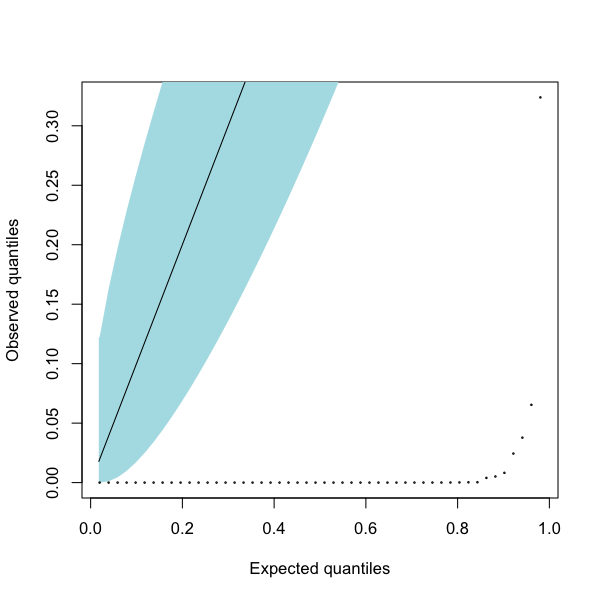

In [73]:
learner_hawkes = estimator_unidim_multi_rep()
learner_hawkes.fit(tlist)
pvals =learner_hawkes.GOF_bootstrap(compensator_func=unidim_EHP_compensator)

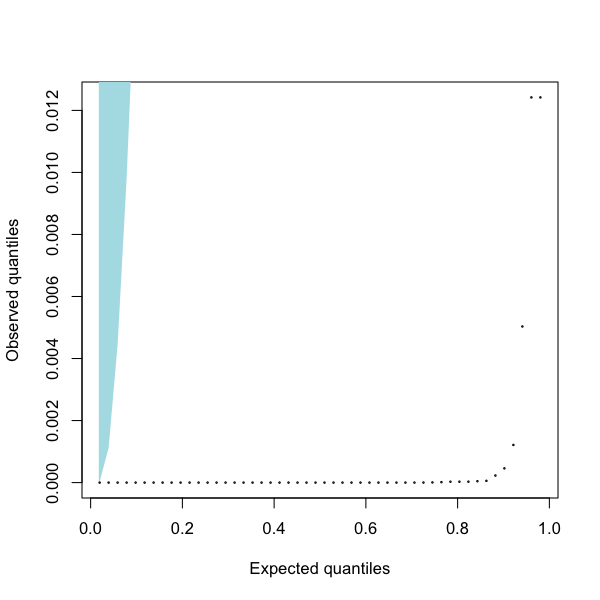

In [74]:
learner_marked_hawkes = estimator_unidim_multi_rep(loss = likelihood_Poisson)
learner_marked_hawkes.fit(tlist)
pvals =learner_marked_hawkes.GOF_bootstrap(compensator_func=poisson_compensator)